In [1]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

%matplotlib inline
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

/Users/Karthik/pyhome/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/Karthik/pyhome/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'bonus'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### for exploring data
# for key, value in data_dict.items():
#     print (key, [item for item in value if item])
#     break

# for key, value in data_dict.items():
#     bonus = value["bonus"]
#     salary = value["salary"]
#     print key, salary, bonus

# for key, value in data_dict.items():
#     print key

In [15]:
### Task 2: Remove outliers

# Removing the entry that is actually the total amount.
data_dict.pop("TOTAL",0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [16]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict



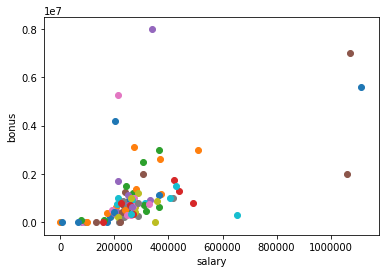

In [18]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#print data

for point in features:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [45]:
### Split data into training data and test data
from sklearn.model_selection import train_test_split

# random_state = 42 is the seed for randomizing the split.
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [47]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()

# Try using decision tree
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)

print pred


[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [48]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# # Example starting point. Try investigating other evaluation techniques!
# from sklearn.cross_validation import train_test_split
# features_train, features_test, labels_train, labels_test = \
#     train_test_split(features, labels, test_size=0.3, random_state=42)
    
    

#evaluation    
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

acc = accuracy_score(labels_test, pred)
ps = precision_score(labels_test, pred)
rs = recall_score(labels_test, pred)

print "acc:", acc
print "precision_score:", ps
print "recall_score:", rs

acc: 0.586206896552
precision_score: 0.0
recall_score: 0.0


In [49]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)